# 1.5 - Getting Quarterly Shock Series

This script uses the individual meeting-day shocks to construct a quarterly monetary policy shock series for quarters starting in all months from April 1995 to October 2013

Denoting the set of shocks $s_{t,i}$ which occur in quarter $t$ by $Q_t$ and the proportion of quarter $t$ that has elapsed when shock $s_{t,i}$ occurs by $\delta_{t,i}$, each quarterly shock $\gamma_t$ is given by...

$$\gamma_t = \sum_{s_{t-1,i} \in Q_{t-1}} \delta_{t-1,i}s_{t-1,i} + \sum_{s_{t,i} \in Q_t} (1-\delta_{t,i})s_{t,i} $$

...following Gertler and Karadi (2015).

### Preamble

This script makes use of...

- Pandas
- NumPy

In [106]:
import pandas as pd
import numpy as np
from pandas.tseries.offsets import DateOffset

### Import Shocks, Including the Nakamura & Steinsson (2018) Series

This block imports all 4 series

In [107]:
shocks_df = pd.read_csv('purged_shocks.csv') # Import the shocks purged in 1.4

shocks_df['Date'] = [pd.Timestamp(x) for x in shocks_df['Date']]

shocks_df = shocks_df.set_index('Date')

### Finding pre-Quarterisation Correlations between Series

In [108]:
shocks_df.corr()

,S_shocks,NS_shocks,S_shocks_raw,NS_shocks_raw
S_shocks,1.000000,0.369997,0.907321,0.344912
NS_shocks,0.369997,1.000000,0.334198,0.934373
S_shocks_raw,0.907321,0.334198,1.000000,0.437455
NS_shocks_raw,0.344912,0.934373,0.437455,1.000000


In [109]:
shocks_df[shocks_df.index < pd.Timestamp('2008-12-01')].corr()

,S_shocks,NS_shocks,S_shocks_raw,NS_shocks_raw
S_shocks,1.000000,0.396429,0.905792,0.372174
NS_shocks,0.396429,1.000000,0.387360,0.949566
S_shocks_raw,0.905792,0.387360,1.000000,0.477287
NS_shocks_raw,0.372174,0.949566,0.477287,1.000000


In [110]:
shocks_df[shocks_df.index >= pd.Timestamp('2008-12-01')].corr()

,S_shocks,NS_shocks,S_shocks_raw,NS_shocks_raw
S_shocks,1.000000,0.342181,0.914596,0.307495
NS_shocks,0.342181,1.000000,0.212658,0.851939
S_shocks_raw,0.914596,0.212658,1.000000,0.365714
NS_shocks_raw,0.307495,0.851939,0.365714,1.000000


### Getting the Gertler and Karadi (2015) Coefficients for Each Meeting Date

This block establishes the proportion of each meeting-day shock that will contribute to shock corresponding to the quarter in which it occurs, and the shock corresponding to the quarter that follows.

In [111]:
## Get all quarter starts from 1994Dec to 2014Jan inclusive. Although quarterly shocks are constructed only for 1995Apr to 2013Oct, the method of summation is easier to carry out when an extra quarter either side of this period is included and then dropped post-calculation.

quarter_starts = [pd.Timestamp('1994-12-01') + DateOffset(months = m) for m in range(0,232)] 

## Initialise Dataframe

quarter_shocks_df = pd.DataFrame(index = quarter_starts)

ante1_dates = []

ante1_coefs = []

ante2_dates = []

ante2_coefs = []

ante3_dates = []

ante3_coefs = []

post1_dates = []

post1_coefs = []

post2_dates = []

post2_coefs = []

post3_dates = []

post3_coefs = []

for date in shocks_df.index:
    
    # This establishes a Boolean for all month starts 3 months either side of the meeting date.
    
    b = (quarter_shocks_df.index <= date + DateOffset(months = 3))*(quarter_shocks_df.index > date + DateOffset(months = -3))
    
    ante1, ante2, ante3, post1, post2, post3 = quarter_shocks_df.loc[b].index # 'ante' is current quarter start and 'post' is next quarter start
    
    ante1_dates.append(ante1)
    
    ante2_dates.append(ante2)
    
    ante3_dates.append(ante3)
    
    post1_dates.append(post1)
    
    post2_dates.append(post2)
    
    post3_dates.append(post3)
    
    ante1_coef = 1 - (date - ante1).days/(post1 - ante1).days # proportion of quarter that has elapsed 
    
    ante1_coefs.append(ante1_coef)
    
    ante2_coef = 1 - (date - ante2).days/(post2 - ante2).days
    
    ante2_coefs.append(ante2_coef)
    
    ante3_coef = 1 - (date - ante3).days/(post3 - ante3).days
    
    ante3_coefs.append(ante3_coef)
    
    post1_coef = 1 - ante1_coef # proportion of quarter that is yet to elapse.
    
    post1_coefs.append(post1_coef)
    
    post2_coef = 1 - ante2_coef
    
    post2_coefs.append(post2_coef)
    
    post3_coef = 1 - ante3_coef
    
    post3_coefs.append(post3_coef)

shocks_df['ante1_date'] = ante1_dates

shocks_df['ante1_coef'] = ante1_coefs

shocks_df['ante2_date'] = ante2_dates

shocks_df['ante2_coef'] = ante2_coefs

shocks_df['ante3_date'] = ante3_dates

shocks_df['ante3_coef'] = ante3_coefs

shocks_df['post1_date'] = post1_dates

shocks_df['post1_coef'] = post1_coefs

shocks_df['post2_date'] = post2_dates

shocks_df['post2_coef'] = post2_coefs

shocks_df['post3_date'] = post3_dates

shocks_df['post3_coef'] = post3_coefs

### Establishing the Quarterly Shocks

This block carries builds the 3 quarterly shock series by carrying out the summation described above.

In [112]:
quarter_shocks_df['s_shock_p'] = np.zeros(len(quarter_shocks_df.index))

quarter_shocks_df['s_shock_r'] = np.zeros(len(quarter_shocks_df.index))

quarter_shocks_df['ns_shock_p'] = np.zeros(len(quarter_shocks_df.index))

quarter_shocks_df['ns_shock_r'] = np.zeros(len(quarter_shocks_df.index))

for qdate in quarter_shocks_df.index: # Loops through quarter starts
    
    for sdate in shocks_df.index: # Loops through meeting dates
        
        if shocks_df.loc[sdate,'ante1_date'] == qdate: # True if quarter start corresponds to quarter in which meeting occurs
            
            quarter_shocks_df.loc[qdate,'s_shock_p'] = (quarter_shocks_df.loc[qdate,'s_shock_p'] + shocks_df.loc[sdate,'S_shocks']*shocks_df.loc[sdate,'ante1_coef'])
            
            quarter_shocks_df.loc[qdate,'ns_shock_p'] = (quarter_shocks_df.loc[qdate,'ns_shock_p'] + shocks_df.loc[sdate,'NS_shocks']*shocks_df.loc[sdate,'ante1_coef'])
            
            quarter_shocks_df.loc[qdate,'s_shock_r'] = (quarter_shocks_df.loc[qdate,'s_shock_r'] + shocks_df.loc[sdate,'S_shocks_raw']*shocks_df.loc[sdate,'ante1_coef'])
            
            quarter_shocks_df.loc[qdate,'ns_shock_r'] = (quarter_shocks_df.loc[qdate,'ns_shock_r'] + shocks_df.loc[sdate,'NS_shocks_raw']*shocks_df.loc[sdate,'ante1_coef'])
        
        elif shocks_df.loc[sdate,'ante2_date'] == qdate: 
            
            quarter_shocks_df.loc[qdate,'s_shock_p'] = (quarter_shocks_df.loc[qdate,'s_shock_p'] + shocks_df.loc[sdate,'S_shocks']*shocks_df.loc[sdate,'ante2_coef'])
            
            quarter_shocks_df.loc[qdate,'ns_shock_p'] = (quarter_shocks_df.loc[qdate,'ns_shock_p'] + shocks_df.loc[sdate,'NS_shocks']*shocks_df.loc[sdate,'ante2_coef'])
            
            quarter_shocks_df.loc[qdate,'s_shock_r'] = (quarter_shocks_df.loc[qdate,'s_shock_r'] + shocks_df.loc[sdate,'S_shocks_raw']*shocks_df.loc[sdate,'ante2_coef'])
            
            quarter_shocks_df.loc[qdate,'ns_shock_r'] = (quarter_shocks_df.loc[qdate,'ns_shock_r'] + shocks_df.loc[sdate,'NS_shocks_raw']*shocks_df.loc[sdate,'ante2_coef'])
        
        elif shocks_df.loc[sdate,'ante3_date'] == qdate: 
            
            quarter_shocks_df.loc[qdate,'s_shock_p'] = (quarter_shocks_df.loc[qdate,'s_shock_p'] + shocks_df.loc[sdate,'S_shocks']*shocks_df.loc[sdate,'ante3_coef'])
            
            quarter_shocks_df.loc[qdate,'ns_shock_p'] = (quarter_shocks_df.loc[qdate,'ns_shock_p'] + shocks_df.loc[sdate,'NS_shocks']*shocks_df.loc[sdate,'ante3_coef'])
            
            quarter_shocks_df.loc[qdate,'s_shock_r'] = (quarter_shocks_df.loc[qdate,'s_shock_r'] + shocks_df.loc[sdate,'S_shocks_raw']*shocks_df.loc[sdate,'ante3_coef'])
            
            quarter_shocks_df.loc[qdate,'ns_shock_r'] = (quarter_shocks_df.loc[qdate,'ns_shock_r'] + shocks_df.loc[sdate,'NS_shocks_raw']*shocks_df.loc[sdate,'ante3_coef'])
            
        elif shocks_df.loc[sdate,'post1_date'] == qdate: # True if quarter start corresponds to quarter after that in which meeting occurs
                
            quarter_shocks_df.loc[qdate,'s_shock_p'] = (quarter_shocks_df.loc[qdate,'s_shock_p'] + shocks_df.loc[sdate,'S_shocks']*shocks_df.loc[sdate,'post1_coef'])
            
            quarter_shocks_df.loc[qdate,'ns_shock_p'] = (quarter_shocks_df.loc[qdate,'ns_shock_p'] + shocks_df.loc[sdate,'NS_shocks']*shocks_df.loc[sdate,'post1_coef'])
            
            quarter_shocks_df.loc[qdate,'s_shock_r'] = (quarter_shocks_df.loc[qdate,'s_shock_r'] + shocks_df.loc[sdate,'S_shocks_raw']*shocks_df.loc[sdate,'post1_coef'])
            
            quarter_shocks_df.loc[qdate,'ns_shock_r'] = (quarter_shocks_df.loc[qdate,'ns_shock_r'] + shocks_df.loc[sdate,'NS_shocks_raw']*shocks_df.loc[sdate,'post1_coef'])
        
        elif shocks_df.loc[sdate,'post2_date'] == qdate: 
                
            quarter_shocks_df.loc[qdate,'s_shock_p'] = (quarter_shocks_df.loc[qdate,'s_shock_p'] + shocks_df.loc[sdate,'S_shocks']*shocks_df.loc[sdate,'post2_coef'])
            
            quarter_shocks_df.loc[qdate,'ns_shock_p'] = (quarter_shocks_df.loc[qdate,'ns_shock_p'] + shocks_df.loc[sdate,'NS_shocks']*shocks_df.loc[sdate,'post2_coef'])
            
            quarter_shocks_df.loc[qdate,'s_shock_r'] = (quarter_shocks_df.loc[qdate,'s_shock_r'] + shocks_df.loc[sdate,'S_shocks_raw']*shocks_df.loc[sdate,'post2_coef'])
            
            quarter_shocks_df.loc[qdate,'ns_shock_r'] = (quarter_shocks_df.loc[qdate,'ns_shock_r'] + shocks_df.loc[sdate,'NS_shocks_raw']*shocks_df.loc[sdate,'post2_coef'])
        
        elif shocks_df.loc[sdate,'post3_date'] == qdate: 
                
            quarter_shocks_df.loc[qdate,'s_shock_p'] = (quarter_shocks_df.loc[qdate,'s_shock_p'] + shocks_df.loc[sdate,'S_shocks']*shocks_df.loc[sdate,'post3_coef'])
            
            quarter_shocks_df.loc[qdate,'ns_shock_p'] = (quarter_shocks_df.loc[qdate,'ns_shock_p'] + shocks_df.loc[sdate,'NS_shocks']*shocks_df.loc[sdate,'post3_coef'])
            
            quarter_shocks_df.loc[qdate,'s_shock_r'] = (quarter_shocks_df.loc[qdate,'s_shock_r'] + shocks_df.loc[sdate,'S_shocks_raw']*shocks_df.loc[sdate,'post3_coef'])
            
            quarter_shocks_df.loc[qdate,'ns_shock_r'] = (quarter_shocks_df.loc[qdate,'ns_shock_r'] + shocks_df.loc[sdate,'NS_shocks_raw']*shocks_df.loc[sdate,'post3_coef'])
            
quarter_shocks_df = quarter_shocks_df.drop(index = quarter_shocks_df.index[:4])

quarter_shocks_df = quarter_shocks_df.drop(index = quarter_shocks_df.index[-5:])

### Finding post-Quarterisation Correlations

In [113]:
quarter_shocks_df.corr()

,s_shock_p,s_shock_r,ns_shock_p,ns_shock_r
s_shock_p,1.000000,0.905644,0.288138,0.240508
s_shock_r,0.905644,1.000000,0.285256,0.383943
ns_shock_p,0.288138,0.285256,1.000000,0.911474
ns_shock_r,0.240508,0.383943,0.911474,1.000000


In [114]:
quarter_shocks_df[quarter_shocks_df.index < pd.Timestamp('2008-12-01')].corr()

,s_shock_p,s_shock_r,ns_shock_p,ns_shock_r
s_shock_p,1.000000,0.881634,0.363973,0.288475
s_shock_r,0.881634,1.000000,0.363664,0.445181
ns_shock_p,0.363973,0.363664,1.000000,0.923191
ns_shock_r,0.288475,0.445181,0.923191,1.000000


In [115]:
quarter_shocks_df[quarter_shocks_df.index >= pd.Timestamp('2008-12-01')].corr()

,s_shock_p,s_shock_r,ns_shock_p,ns_shock_r
s_shock_p,1.000000,0.953639,0.099945,0.147099
s_shock_r,0.953639,1.000000,0.124123,0.274341
ns_shock_p,0.099945,0.124123,1.000000,0.877663
ns_shock_r,0.147099,0.274341,0.877663,1.000000


### Export to *.csv*

In [116]:
quarter_shocks_df.to_csv('quarter_shocks.csv')

### Producing Figure 3

This block takes "baseline" quarters - those starting in January, April, July and October - for both my purged series and that of Nakamura and Steinsson and produces a bar chart depicting each.

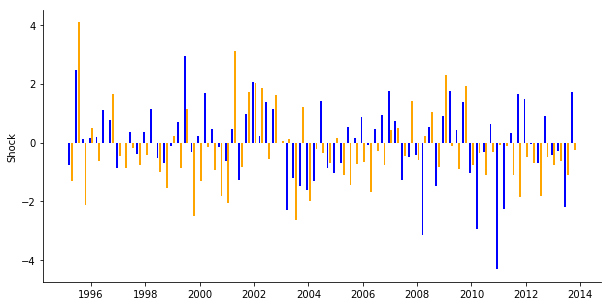

In [117]:
graph_shocks_df = quarter_shocks_df.loc[[pd.Timestamp('1995-04-01') + DateOffset(months = m) for m in range(0,223,3)]]

from matplotlib import pyplot as plt

y1 = -1*graph_shocks_df.s_shock_p.values/np.abs(graph_shocks_df.s_shock_p.values).mean()

x1 = graph_shocks_df.index + pd.DateOffset(days = -18)

y2 = -1*graph_shocks_df.ns_shock_p.values/np.abs(graph_shocks_df.ns_shock_p.values).mean()

x2 = graph_shocks_df.index + pd.DateOffset(days = 18)

fig = plt.figure(figsize = (10,5))

plt.bar(x1,y1, width = 25, color = 'b')

plt.bar(x2,y2, width = 25, color = 'orange')

plt.ylabel('Shock')

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

plt.show()

### Number of Quarters in which Signs of Daily Date Series and Nakamura and Steinsson (2018) Series Differ 

In [118]:
sum(shocks_df.S_shocks.values*shocks_df.NS_shocks.values < 0)

52